# What will be my new recruit's salary?

__author__ = Rupam Banerjee <br>
__email__ = rupamanu@buffalo.edu

## Part 1 - PROBLEM STATEMENT

The main idea behind this project is to build a model that would help predict salary for a particular job/role based on the known salary data. This model can be used as a guide while deciding on new hire's compensation and can also be used to retain old employees by providing them with the competitive compensation and hikes based on the current job market.

## Part 2 - DISCOVER

### --- About the Data ---

There are three datasets each having 1 million rows: 
1. train_features - consists of input variables.
2. train_salaries - consists of target variable.
3. test_dataset - consists of input variables for which target variable is to be predicted.

Brief description of the variables:<br>
**1. JobId**: Unique ID to identify each job/role<br>
**2. CompanyId**: ID of the company in which the job/role is present<br>
**3. yearsExperience**: Years of Experience<br>
**4. JobType**: Position/Role at the company (CEO, CFO, CTO, Vice President, Manager, Janitor, Senior, or Junior position)<br>
**5. degree**: Highest degree of education (Doctoral, Masters, Bachelors, High School, or None)<br>
**7. major**: Area/Concentration of study (Biology, Business, Chemistry, Computer Science, Engineering, Literature, Math, Physics, or None)<br>
**8. Industry**: Domain of the job (Auto, Education, Finance, Health, Oil, Service, or Web)<br>
**9. Miles From Metropolis**: Distance of job location from Metropolis<br>
**10. Salary**: Salary for the particular job/role.

### ---- 1 Load required libraries ----

In [1]:
#For Accessing data from AWS Redshift
import os
import psycopg2

#For Data Manipulation
import pandas as pd
import numpy as np

#For Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#For Building models
from sklearn.model_selection import KFold, train_test_split, cross_validate
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm as lgbm

#Others
import warnings
warnings.filterwarnings("ignore")

In [32]:
def get_data_from_aws(query):
    '''Pull data from AWS Redshift to a dataframe in Python'''
    conn = db_connection()
    try:
        df = pd.read_sql(query, conn)
    finally:
        conn.close()
    return df  

def db_connection():
    '''Obtain the AWS database details'''
    conn = psycopg2.connect(
        host = os.environ.get('HOST'),
        port = os.environ.get('PORT'),
        user = os.environ.get('USER'),
        password = os.environ.get('PASSWORD'),
        database = os.environ.get('DATABASE'),
    )
    return conn

def clean_data(df):
    '''Remove salaries less than or equal to zero and negative values if any in years of experience and miles 
    from metropolis '''
    clean_df = df[(df['salary'] > 0) & (df['yearsexperience'] >= 0) & (df['milesfrommetropolis'] >= 0)]
    return clean_df

def feature_plot(df, attribute):
    ''' Plotting the features for EDA'''
    mean = df.groupby(attribute)[target].mean()
    levels = mean.sort_values().index.tolist()
    
    if df[attribute].dtype == 'O':
        plt.figure(figsize = (15,6))
        
        sns.violinplot(x = df[attribute],y = df[target], inner = 'quartile', order = levels)
        plt.show()
    
    elif df[attribute].dtype in ['int64', 'float64']:
        plt.figure(figsize = (10,6))

        sns.scatterplot(x = df[attribute],y = df[target])
        plt.show()
        
    else:
        print('Datatype not valid.')

def dtype_conv(df, dtype, features):
    '''Convert the features to desirable format'''
    if dtype in ('int64', 'float64', 'O'):
        for i in range(len(features)):
            df[features[i]] = df[features[i]].astype(dtype)
    else:
        print('dtype not understood')
    return df

def transform_nom(df):
    '''Transform to nominal variables'''
    job_dict = {"JANITOR":0, "JUNIOR":1, "SENIOR":2, "MANAGER":3, "VICE_PRESIDENT":4, "CFO":5, "CTO":5, "CEO": 6}
    df['jobtype'].replace(job_dict, inplace=True)

    degree_dict = {"NONE":0, "HIGH_SCHOOL":1, "BACHELORS":2, "MASTERS":3, "DOCTORAL":4}
    df['degree'].replace(degree_dict, inplace=True)
    return df

def one_hot_encoding(df, categorical_features):
    """Encode a list of categorical features using a one-hot scheme"""
    for feature in categorical_features:
        data_dummy = pd.get_dummies(df[feature], prefix=feature)
        df.drop([feature], axis = 1, inplace = True)
        df = pd.concat((df, data_dummy), axis = 1)
    return df

def standardize(df, numerical_features):
    '''Standardize the numerical variables'''
    for i in range(len(numerical_features)):
        df[numerical_features[i]] = (df[numerical_features[i]] - df[numerical_features[i]].mean())/\
        (df[numerical_features[i]].max() - df[numerical_features[i]].min())
    return df

def sep_train_test(df):
    '''Separate train and test datasets'''
    train_df=df[df['type'] == 'train']
    test_df=df[df['type'] == 'test']
    train_df.drop('type', axis = 1, inplace = True)
    test_df.drop(['type','salary'], axis = 1, inplace = True)
    y_train_df = train_df['salary']
    x_train_df = train_df.drop('salary', axis = 1)
    return x_train_df, y_train_df, test_df

def evaluate_model(models, x_train, y_train, k_folds, n_jobs = -1):
    '''Evaluate models using k-Fold Cross validation '''
    for i in range(len(models)):
        model_cv = cross_validate(models[i], x_train, y_train, scoring = mse_scorer, cv = k_folds, return_train_score = True, 
                              return_estimator = True, verbose = 5, n_jobs = n_jobs)
        model_mse_score = (-1)*model_cv['test_score'].mean()
        cv_std=np.std(model_cv['train_score'])
        print('Model:\n'+str(models[i]) + '\n\n----Results----\nMSE Score: ' + str(model_mse_score) + '\nCV_std_dev: ' 
              + str(cv_std))

def fit_predict(train_feature_df, train_target_df, test_feature_df, model):
    '''fit and predict the model'''
    model.fit(train_feature_df, train_target_df)
    y_pred = model.predict(test_feature_df)
    return model, y_pred

def final_dataset(y_pred,orig_test_df):
    '''Create the final predicted dataset'''
    y_pred = pd.DataFrame(y_pred).rename(columns = {0:'salary'})
    final_dataset = pd.merge(orig_test_df,y_pred, left_index = True, right_index = True)
    return final_dataset

def save_results(model,final_dataset, train_feature_df):
    '''Save the model and final predicted dataset to local disk'''
    feat_imp = pd.DataFrame({'Features':train_feature_df.columns,'Coefficients':model.feature_importances_})
    feat_imp.to_csv('Feature Importance.csv')
    with open('model.txt', 'w') as file:
        file.write(str(model))
    final_dataset.to_csv('Predicted Dataset.csv')

def visualize_features(train_feature_df, model):
    '''visualize the importance of features after model execution'''
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({'feature':train_feature_df.columns, 'importance':importances})
    feature_importances.sort_values(by = 'importance', ascending = False, inplace = True)
    plt.figure(figsize = (15,6))
    sns.barplot(x = feature_importances.feature, y = feature_importances.importance)
    plt.xticks(rotation = 45)

### ---- 2 Load and examine the data ----

In [33]:
#Initialize the queries
query_train_features = "SELECT * FROM train_features"
query_test_features= "SELECT * FROM test_features"
query_train_salaries= "SELECT * FROM train_salaries"

#Extract the data from AWS into dataframes
feat_train = get_data_from_aws(query_train_features)
target_train = get_data_from_aws(query_train_salaries)
feat_test = get_data_from_aws(query_test_features)

#Merge the train features with train target variable
hr_train = pd.merge(feat_train, target_train, on = 'jobid')

In [4]:
#Overview of the data
print('There are ' + str(hr_train.shape[0]) +' rows and ' + str(hr_train.shape[1]) + ' columns.')
hr_train.head()

There are 1000000 rows and 9 columns.


,jobid,companyid,jobtype,degree,major,industry,yearsexperience,milesfrommetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
2,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
3,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
4,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31


### ---- 3 Clean the data ----

#### Step 1: Check for datatypes

In [5]:
hr_train.dtypes

jobid                  object
companyid              object
jobtype                object
degree                 object
major                  object
industry               object
yearsexperience         int64
milesfrommetropolis     int64
salary                  int64
dtype: object

#### Step 2: Check for nulls

In [6]:
#Percentage of NULL values in the data
hr_train.isnull().sum()/hr_train.shape[0]*100

jobid                  0.0
companyid              0.0
jobtype                0.0
degree                 0.0
major                  0.0
industry               0.0
yearsexperience        0.0
milesfrommetropolis    0.0
salary                 0.0
dtype: float64

No Null values are found.

#### Step 2: Check for duplicates

In [7]:
print('There are '+ str(hr_train.jobid.duplicated().sum())+' duplicates in our dataset.')

There are 0 duplicates in our dataset.


#### Step 3: Identify and summarize categorical and numerical variables

In [8]:
cat_var=hr_train.select_dtypes('O')
num_var=hr_train.select_dtypes([np.number])

Summarize categorical variables:

In [9]:
cat_var.describe()

,jobid,companyid,jobtype,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684561520,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


Summarize numerical variables:

In [10]:
num_var.describe()

,yearsexperience,milesfrommetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


### ---- 4 Explore the data (EDA) ----

In [11]:
#Set the target variables name
target = 'salary'

#### Step 1:  Visualize the Target Variable

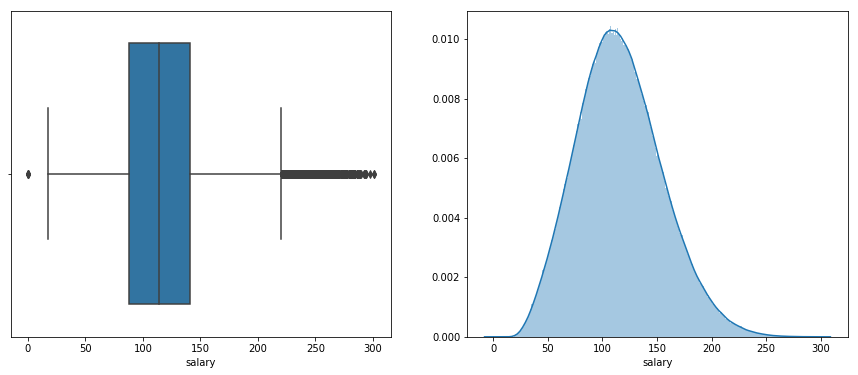

In [12]:
#Boxplot
fig, axes = plt.subplots(ncols = 2, figsize = (15,6))
sns.boxplot(hr_train[target], ax = axes[0])
#Histogram
# plt.subplot(1,2,2)
sns.distplot(hr_train[target], bins = 300, ax = axes[1])
plt.show()

##### Observation: The salary is approximately normally distributed.

#### Step 2: Visualize the relationship between independent and dependent variable

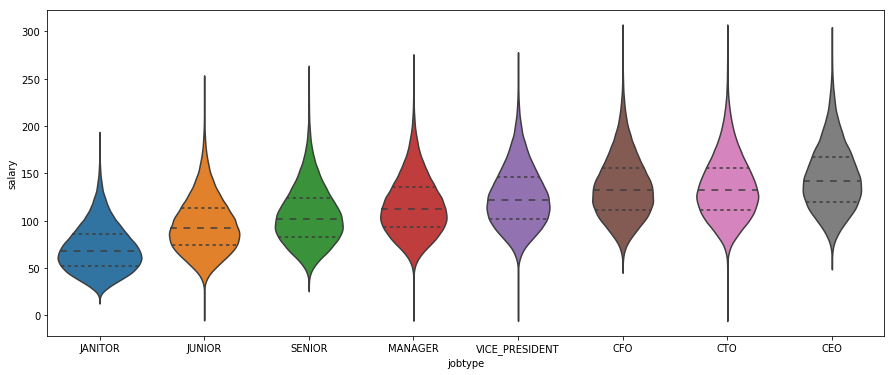

In [28]:
feature_plot(hr_train,'jobtype')

##### Observation: The salary increases as the job_type moves up the ladder based on hierarchy.

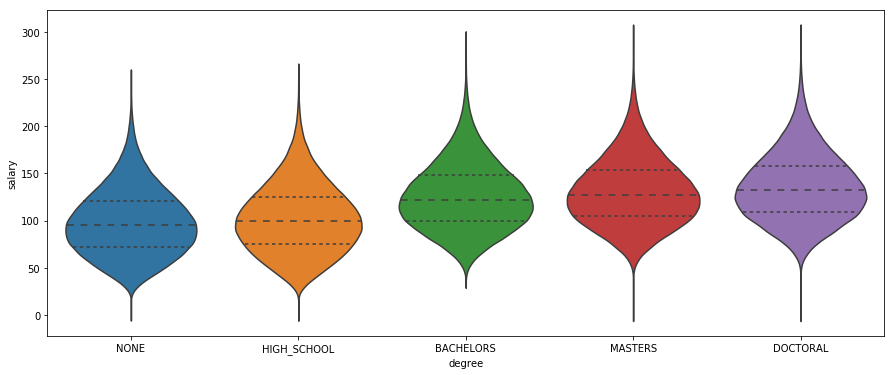

In [29]:
feature_plot(hr_train, 'degree')

##### Observation: The salary increases as the degree of education goes higher.

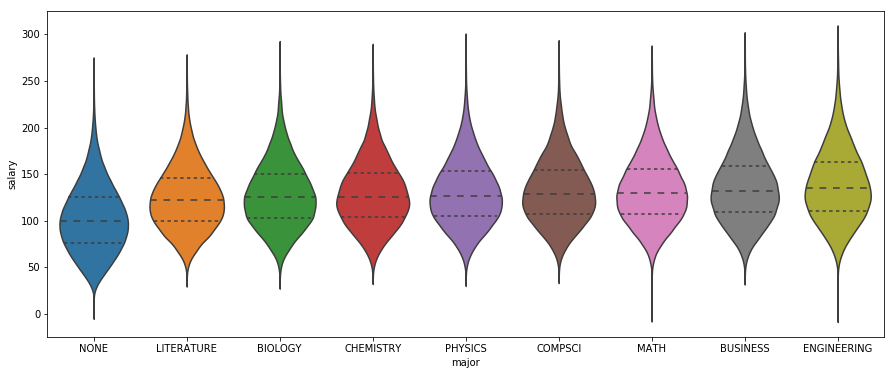

In [30]:
feature_plot(hr_train, 'major')

##### Observation: There is no significant difference in salaries based on majors except for no majors (NONE).

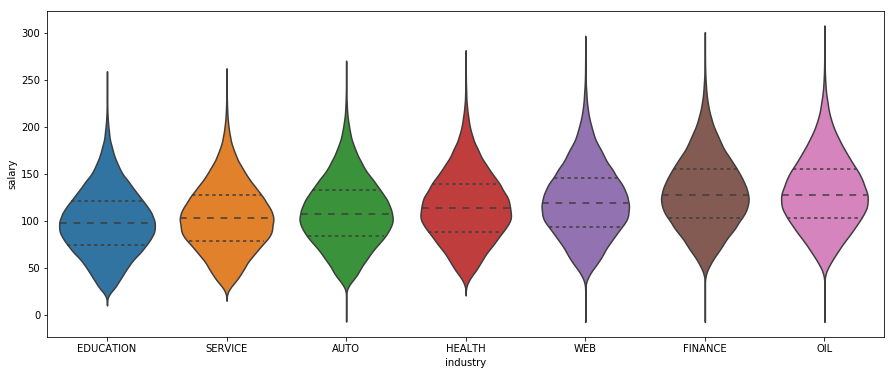

In [31]:
feature_plot(hr_train, 'industry')

##### Observation: Oil and Finance Industries pay higher compared to other industries.

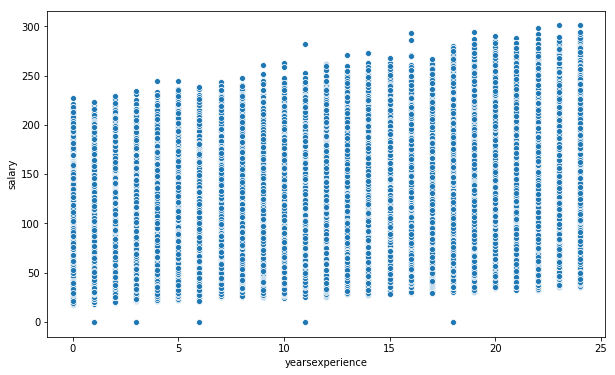

In [17]:
feature_plot(hr_train, 'yearsexperience')

##### Observation: We cannot see a very clear positive relationship between salary and yearsexperience. Hence, we will confirm it in later steps by looking into the correlation matrix.

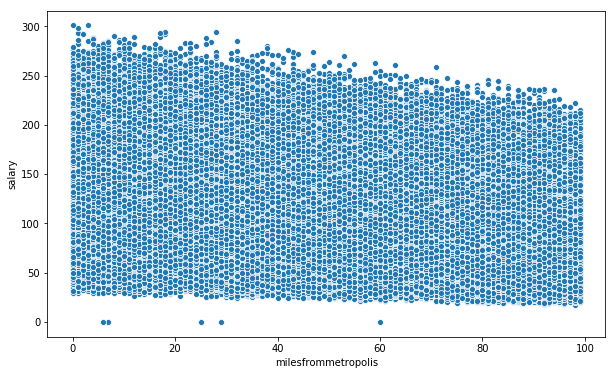

In [18]:
feature_plot(hr_train, 'milesfrommetropolis')

##### Observation: We cannot see a very clear positive relationship between salary and milesfrommetropolis. Hence, we will confirm it in later steps by looking into the correlation matrix.

### ---- 5 Establish a baseline ----

As we have continuous variable as our target variable, we will use MSE as our metric during 5-fold cross-validation for performance evaluation of our models. <br><br>
Assuming that this dataset is used by one of the hypothetical companies, the least they can have is the average salary based on few features as their baseline model. In this case,  as we can see that Industry, Job Type and degree features affect the salary significantly, so we will consider them to calculate the average salary and build our baseline model.

In [19]:
def baseline_model(df, attributes, kfolds):
    '''Baseline model with k-fold cross-validation'''
    kf=KFold(n_splits=kfolds, shuffle=True, random_state=42)
    MSE=0
    
    for i in range(kfolds):
        train_index, test_index=next(kf.split(df), None)
        hr_train_1, hr_test_1=df.iloc[train_index], df.iloc[test_index]

        baseline_salary=hr_train_1.groupby(attributes).mean()
        hr_test_with_pred=pd.merge(hr_test_1,baseline_salary,how='left',on=attributes)
        mse +=np.mean((hr_test_with_pred['salary_x']-hr_test_with_pred['salary_y'])**2)
    mse_baseline=mse/kfolds
    return mse_baseline

In [20]:
#Implement baseline model
mse_baseline=baseline_model(hr_train, ['industry', 'jobtype', 'degree'], 5)
mse_baseline

734.6979727914985

So, here we can see that our baseline model is having a MSE of 734.70. The RMSE be 27.10 which means that the salary will be in the range of +/- $27.10k.<br><br>
Now, how do we check whether our model is good?<br>
One way is to find out how much does the RMSE varies with the standard deviation of the target variable:

In [21]:
np.sqrt(mse_baseline)/hr_train.salary.std()*100

70.00712115329699

Thus 70% of the standard deviation is covered by our baseline model. This is a obviously an improvement but we should aim to lower it down to 50% which means the MSE should be approximately 360.

### ---- 6 Decide on which other models to implement ----

The baseline model only considered three variables into picture: 'Industry, JobType' and 'Degree' but we need to consider other features too. As the dataset is quite balanced, we can use several low bias learning algorithms. I have selected the below three in this case:
1. Ridge Regression Model
2. Lasso Regression Model
3. Decision Trees using Gradient Boost Model

The reason I used the Regularized Regression models is because they are simple yet robust and reduce the influence of less important features. Next, I considered Decision trees using Gradient Boosting Model because of its efficiency in terms of memory and overall speed. Of course the speed depends on maximum_depth and number of leaves, but its GPU support feature that helps you run jobs parallely, increases the overall speed.

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [34]:
#Initialize the queries
query_train_features = "SELECT * FROM train_features"
query_test_features= "SELECT * FROM test_features"
query_train_salaries= "SELECT * FROM train_salaries"

#Extract the data from AWS into dataframes
feat_train=get_data_from_aws(query_train_features)
target_train=get_data_from_aws(query_train_salaries)
feat_test=get_data_from_aws(query_test_features)

#Merge the train features with train target variable
hr_train=pd.merge(feat_train, target_train, on='jobid')

#Merge train and test set
hr_train['type']='train'
feat_test['type']='test'
hr_df=pd.concat([hr_train,feat_test], axis=0)

In [35]:
#Drop the unneccessary columns
hr_df.drop(['jobid', 'companyid'], axis=1, inplace=True)

#### a. Transform jobType and degree to ordinal variables

In [36]:
#Transforming features
jobtype_dict = {"JANITOR":0, "JUNIOR":1, "SENIOR":2, "MANAGER":3, "VICE_PRESIDENT":4, "CFO":5, "CTO":5, "CEO": 6}
hr_df.jobtype.replace(jobtype_dict, inplace=True)

degree_dict = {"NONE":0, "HIGH_SCHOOL":1, "BACHELORS":2, "MASTERS":3, "DOCTORAL":4}
hr_df.degree.replace(degree_dict, inplace=True)

#### b. One hot encoding the categorical variables

In [37]:
#Segregating the numerical and categorical variables
cat_var=['major','industry']
num_var=['jobtype','degree','yearsexperience','milesfrommetropolis']

In [38]:
hr_df=one_hot_encoding(hr_df,cat_var)

#### c. Standardizing the numerical variables

In [39]:
hr_df=standardize(hr_df, num_var)

In [40]:
hr_df.head()

,degree,jobtype,milesfrommetropolis,salary,type,yearsexperience,major_BIOLOGY,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,0.296548,0.291902,0.338103,130.0,train,-0.083219,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0.546548,0.125235,-0.116443,137.0,train,-0.083219,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0.046548,0.125235,-0.338665,163.0,train,-0.166552,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,-0.453452,0.291902,-0.257857,178.0,train,0.458448,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,-0.203452,-0.541431,0.045173,31.0,train,-0.458219,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


#### d. Find the correlation between the variables

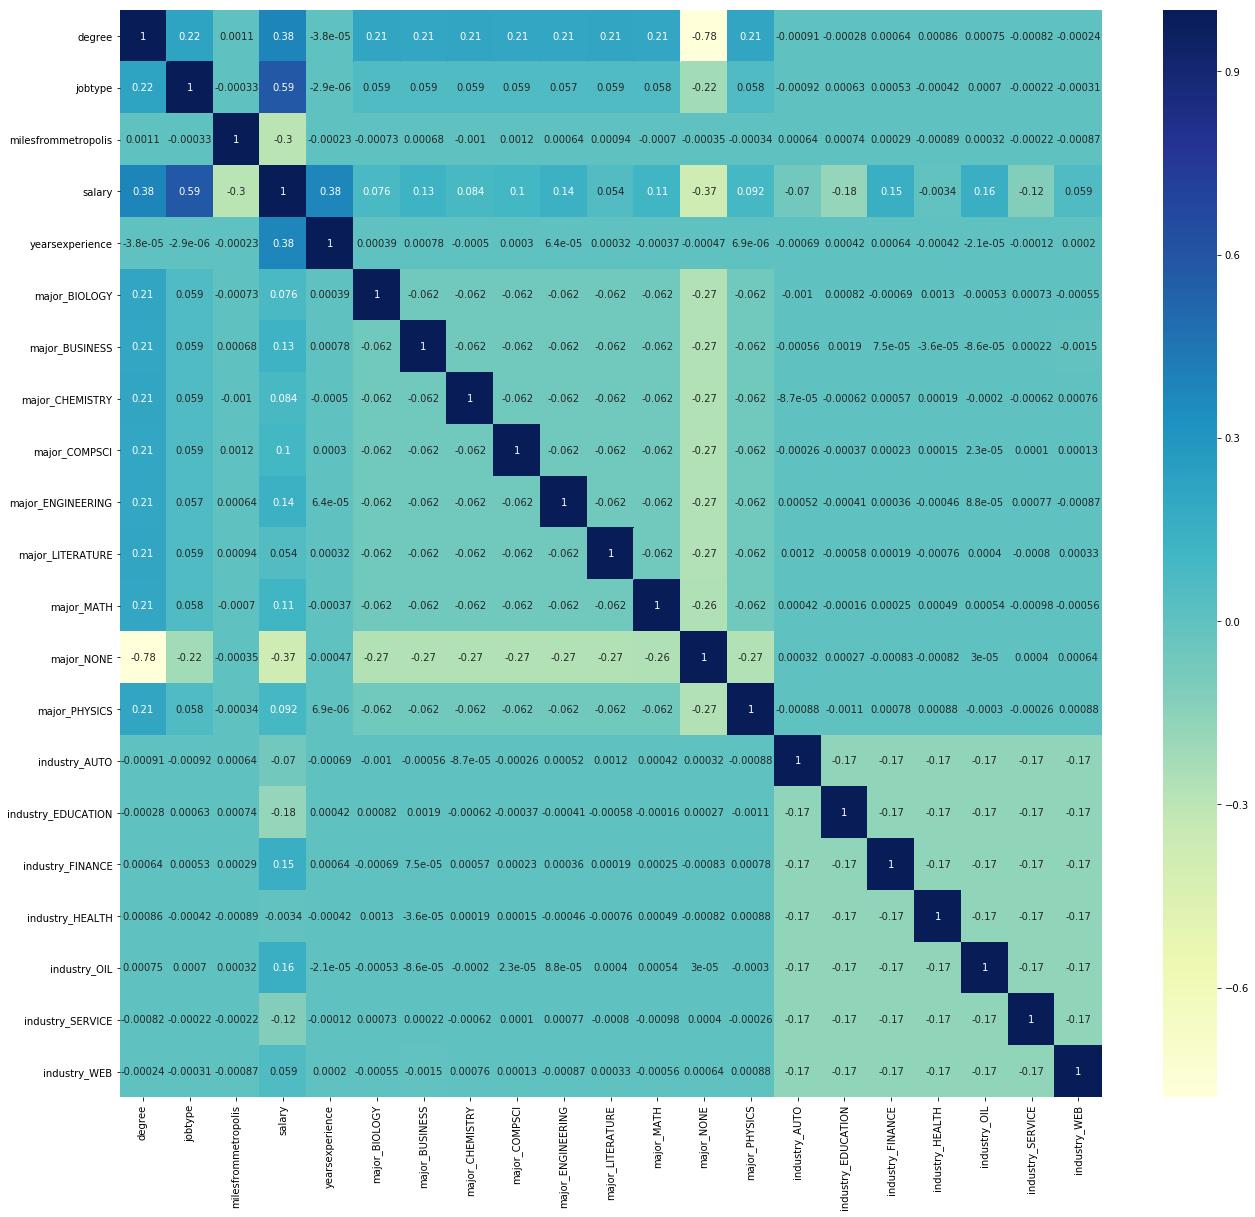

In [41]:
corr=hr_df.corr()
plt.figure(figsize=(22,20))
sns.heatmap(corr, cmap='YlGnBu', annot=True)
plt.show()

##### Observation: degree, jobType, milesFromMetropolis and yearsExperience are correlated with salary. Thus, this clears our earlier doubt about relationship of salary with milesFromMetropolis and yearsExperience.

#### e. Separate the train and test datasets

In [42]:
feat_train_df, target_train_df, feat_test_df=sep_train_test(hr_df)

#### f. Create a test set for validation later

In [44]:
feat_train_1, feat_test_1, target_train_1, target_test_1=train_test_split(feat_train_df,target_train_df, test_size=0.1, 
                                                                          random_state=10)

### ---- 8 Create models and scorer ----

#### a. Tuning the parameters of the models by hand

In [45]:
#Regression Models
Lasso_Reg=Lasso(alpha=0.05)
Ridge_Reg=Ridge(alpha=0.05)

#Light GBM Model
gbm=lgbm.LGBMRegressor(learning_rate=0.1, reg_lambda=0.01, reg_alpha=0.1, n_jobs = -1)

#Create a list of models
models=[Lasso_Reg, Ridge_Reg, gbm]

#### b. Build the Scorer

In [46]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

### ---- 9 Test models ----

In [47]:
evaluate_model(models, feat_train_1, target_train_1, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.6s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model:
Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

----Results----
MSE Score: 385.7861735096135
CV_std_dev: 0.21386890286249163


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model:
Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

----Results----
MSE Score: 385.295023746613
CV_std_dev: 0.2138471050037741


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.8s remaining:   32.7s


Model:
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.1, reg_lambda=0.01, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

----Results----
MSE Score: 357.41796453748617
CV_std_dev: 0.11461330245681638


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.3s finished


We can see that GBM performed the best out the three models and also reached our target MSE of less than 360.

### ---- 10 Select best model  ----

In [48]:
evaluate_model(models,feat_test_1, target_test_1, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model:
Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

----Results----
MSE Score: 383.87714868701113
CV_std_dev: 1.0711194836560316


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model:
Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

----Results----
MSE Score: 383.38785509393267
CV_std_dev: 1.0704932741629043
Model:
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.1, reg_lambda=0.01, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

----Results----
MSE Score: 359.81117216095987
CV_std_dev: 1.0921721852454411


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


We can see that LGB model performed the better among the three, thus we will use that model in our production code.

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [49]:
def production_code(query_train_features,query_train_target,query_test_features):
    '''Automate the entire pipeline starting from loading the dataset, implementing the model to saving the results'''
    #Load, clean and merge the files
    print('Loading the data...')
    feat_train=get_data_from_aws(query_train_features)
    target_train=get_data_from_aws(query_train_target)
    feat_test=get_data_from_aws(query_test_features)
    hr_train=pd.merge(x_train, y_train, on='jobid')
    print('Cleaning the data...')
    hr_train=clean_data(hr_train)
    print('Merging the data...')
    hr_train['type']='train'
    feat_test['type']='test'
    hr_df=pd.concat([hr_train,feat_test], axis=0)
    
    #Drop the unneccessary columns
    print('Dropping unneccessary columns...')
    hr_df.drop(['jobid', 'companyid'], axis=1, inplace=True)
    
    print('Feature Engineering...')
    #Transform to nominal
    hr_df=transform_nom(hr_df)
    
    #Assign proper dtype for the numerical and categorical variables
    cat_var=['major','industry']
    num_var=['jobtype','degree','yearsexperience','milesfrommetropolis']
    
    hr_df=dtype_conv(hr_df,'O',cat_var)
    hr_df=dtype_conv(hr_df,'int64', num_var)
    
    #One hot encoding
    hr_df=one_hot_encoding(hr_df,cat_var)
    
    #Standardization
    hr_df=standardize(hr_df,num_var)
    
    #Separate train and test tests
    print('Splitting the data into train and test sets...')
    feat_train_1, target_train_1, feat_test_1=sep_train_test(hr_df)
    
    #Initialize model
    print('Initialize GBM model...')
    gbm=lgbm.LGBMRegressor(learning_rate=0.1, reg_lambda=0.01, reg_alpha=0.1, n_jobs = -1)
    
    #Evaluate model
    print('Evaluating GBM model..')
    evaluate_model([gbm], feat_train_1, target_train_1, 5)
    
    #Fit the model on train dataset
    print('\nImplementing GBM model on test data..')
    model, y_pred=fit_predict(feat_train_1, target_train_1, feat_test_1, gbm)
    predicted_dataset=final_dataset(y_pred,feat_test_1)
    
    #Save the model and final predicted dataset
    print('Saving the following results on disk:\n1. Model details\n2. Predicted Dataset\n3. Feature Importance Details')
    save_results(model,predicted_dataset,feat_train_1)
    
    #Visualize the features
    print('\nVisualizing the importance of features:')
    visualize_features(feat_train_1,model)

### ---- 12 Deploy solution ----

Loading the data...
Cleaning the data...
Merging the data...
Dropping unneccessary columns...
Feature Engineering...
Splitting the data into train and test sets...
Initialize GBM model...
Evaluating GBM model..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.3s remaining:   42.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished


Model:
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.1, reg_lambda=0.01, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

----Results----
MSE Score: 357.16080805416266
CV_std_dev: 0.32844895790894546

Implementing GBM model on test data..
Saving the following results on disk:
1. Model details
2. Predicted Dataset
3. Feature Importance Details

Visualizing the importance of features:


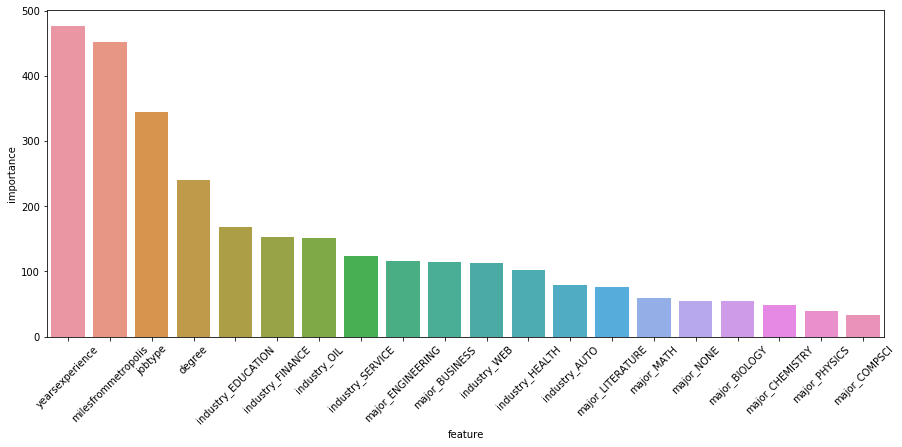

In [50]:
query_train_features = "SELECT * FROM train_features"
query_test_features= "SELECT * FROM test_features"
query_train_salaries= "SELECT * FROM train_salaries"
production_code(query_train_features,query_train_salaries,query_test_features)

### Summary:
We can see that yearsExperience, milesFromMetropolis,  jobType and degree are of highest importance in our preferred model. This information can be used by companies to decide on their compensation strategies for new hires and keep a control on their payroll expenses.